In [157]:
import nltk, sys, string, gensim, unicodedata, re
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## Analysis of small.txt file

In [78]:
punctCatgs = {'P', 'S'}
def isPunct(tkn):
    if len(tkn) > 2:
        return False
    elif len(tkn) == 1 and unicodedata.category(tkn)[0] in punctCatgs:
        return True
    elif len(tkn) == 2 and (tkn=="``" or tkn=="''"):
        return True
    else:
        return False

def tokenize(txt):
    s = {'P', 'S'}
    tkns = nltk.word_tokenize(txt.casefold())
    return [t for t in tkns if not isPunct(t)]

In [79]:
with open('./data/small.txt', 'r', encoding='utf-8') as f:
    sents = [tokenize(line) for line in f.read().split('\n')]

print(sents[100:104])

[['eds', 'shareholders', 'to', 'receive', '25.00', 'per', 'share', 'in', 'cash', 'for', 'each', 'eds', 'share'], ['the', 'developer', 'have', 'to', 'present', 'the', 'contract', 'to', 'the', 'bank', 'in', 'order', 'to', 'release', 'the', 'funds'], ['we', "'re", 'now', 'examining', 'what', 'role', 'the', 'united', 'nations', 'can', 'play', 'in', 'resolution', 'of', 'this', 'conflict', 'he', 'said', 'our', 'ambassador', 'to', 'the', 'united', 'nations', 'has', 'begun', 'consultations', 'in', 'this', 'regard'], ['from', 'his', 'remark', 'we', 'can', 'understand', 'that', 'in', 'the', 'private', 'talks', 'in', 'deauville', 'and', 'the', 'discussions', 'before', 'deauville', 'the', 'russians', 'tried', 'to', 'blame', 'romania', 'for', 'the', 'transdniester', 'impasse']]


Build a word2vec model

In [143]:
mdl = Word2Vec(sentences=sents, size=100, window=5, min_count=2, sg=1, negative=8)

Get the first two principal components of several terms

In [148]:
wrds = ['paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia', 'cat', 
        'dog', 'truck', 'train', 'two', 'three', 'four']
v = np.vstack([mdl.wv[s] for s in wrds]).T
pc2 = PCA(n_components=2)
pc2.fit(v);

Plot the PC1 and PC2 along with text annotation

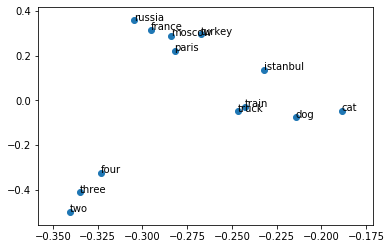

In [146]:
plt.scatter(pc2.components_[0], pc2.components_[1])
for n,w in enumerate(wrds):
    plt.text(pc2.components_[0,n], pc2.components_[1,n], w)
plt.show()

In [ ]:
################################################################################

## Google News Pre-trained Embeddings

In [158]:
googFile = './data/GoogleNews-vectors-negative300.bin'
googMdl = KeyedVectors.load_word2vec_format(googFile, binary=True)

In [172]:
googMdl.most_similar('fascinating')

[('interesting', 0.762306809425354),
 ('intriguing', 0.7245113849639893),
 ('enlightening', 0.6644250750541687),
 ('captivating', 0.6459898352622986),
 ('facinating', 0.641668438911438),
 ('riveting', 0.6324825286865234),
 ('instructive', 0.6210989356040955),
 ('endlessly_fascinating', 0.6188612580299377),
 ('revelatory', 0.6170244216918945),
 ('engrossing', 0.6126049757003784)]

In [173]:
googMdl.most_similar('cultivate')

[('cultivating', 0.7274794578552246),
 ('cultivated', 0.6766660213470459),
 ('nurture', 0.6695472002029419),
 ('cultivates', 0.6159787178039551),
 ('develop', 0.6053071022033691),
 ('Cultivate', 0.5910323858261108),
 ('Cultivating', 0.5667836666107178),
 ('nuture', 0.5440778732299805),
 ('nourish', 0.5328434109687805),
 ('grow', 0.5282535552978516)]

In [176]:
googMdl.distances('Vietnam', ['Spain', 'China', 'Egypt'])

array([0.78796744, 0.49617392, 0.7123459 ], dtype=float32)

In [177]:
googMdl.distances('mother', ['father', 'teacher', 'ocean'])

array([0.20985174, 0.6231039 , 0.8943766 ], dtype=float32)

In [182]:
googMdl.most_similar_cosmul(['puppies', 'cat'], ['dog'], 1)

[('kittens', 0.9692491292953491)]

In [189]:
googMdl.most_similar_cosmul(['read', 'music'], ['book'], 1)

[('listen', 0.915989875793457)]

In [190]:
googMdl.most_similar_cosmul(['hot', 'winter'], ['summer'], 1)

[('cold', 0.8846044540405273)]

In [217]:
googMdl.distances('small', ['tiny', 'large', 'ice'])

array([0.28120732, 0.26688498, 0.88406587], dtype=float32)

In [218]:
del googMdl

## Word Embedding for Translations

In [220]:
sents[:10]

[['ask',
  'truman',
  'burbank',
  'an',
  'ordinary',
  'person',
  'who',
  'has',
  'accidentally',
  'learned',
  'that',
  'his',
  'life',
  'is',
  'a',
  'popular',
  'tv',
  'show'],
 ['he',
  "'s",
  'fighting',
  'at',
  'a',
  'weight',
  'he',
  "'s",
  'comfortable',
  'at'],
 ['he',
  'is',
  'far',
  'better',
  'in',
  'his',
  'ironic',
  'comments',
  'on',
  'war',
  'like',
  "'my",
  'sweet',
  'old',
  'etcetera',
  'and',
  "'plato",
  'told/him',
  'and',
  'in',
  'his',
  'ability',
  'to',
  'catch',
  'the',
  'flavour',
  'of',
  'low-life',
  'speech',
  'as',
  'in',
  "'yguduh"],
 ['our',
  'strong',
  'team',
  'performed',
  'extremely',
  'well',
  'in',
  'safety',
  'environmental',
  'protection',
  'production',
  'and',
  'product',
  'sales'],
 ['a',
  'western',
  'theologian',
  'has',
  'said',
  'that',
  'we',
  'may',
  'proclaim',
  'the',
  'whole',
  'truth',
  'of',
  'orthodoxy',
  'and',
  'at',
  'the',
  'same',
  'time',
  'defa